In [ ]:
%pip install --upgrade tdmclient
%pip install opencv-contrib-python

In [1]:
import warnings
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt

from global_variables import *
from computer_vision import *
from kalman import *
from global_navigation import *
from local_navigation import *
from motion_control import *


# Functions for communication with the Thymio

In [2]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [3]:
@tdmclient.notebook.sync_var
def apply_motor_commands(v_r,v_l):
  # Applies the commands v_l and v_r to the Thymio's motors
  # Inputs : v_r (int), v_l (int)
  # Outputs: None

  global motor_left_target, motor_right_target
  motor_left_target = v_l
  motor_right_target = v_r

@tdmclient.notebook.sync_var
def stop_Thymio():
  # Stops the Thymio robot

  global motor_left_target,motor_right_target
  motor_left_target = 0
  motor_right_target = 0

@tdmclient.notebook.sync_var
def get_motor_speeds():
  # Returns the speeds of the motors : motor.left.speed and motor.right.speed variables from the Thymio
  # Outputs : left_motor_speed (int), right_motor_speed (int)

  global motor_left_speed, motor_right_speed
  return motor_right_speed, motor_left_speed

@tdmclient.notebook.sync_var
def get_prox_sensors():
  # Returns the values of the proximity sensors of the Thymio in a list. Indices [0-4] correspond to the front facing ones (indexed from left to right) and [5-6] are the backwards facing sensors
  # Outputs : prox_horizontal (list of ints of length 7)

  global prox_horizontal
  return prox_horizontal

# Kalman Fitler Update function

In [4]:
# KALMAN FILTER GLOBAL FUNCTIONS ----------------------------------------

def update_robot_pose_EKF(X_old, P_old, frame):
  # Returns the updated state vector X = [x, y, theta].T of the robot pose using the Kalman filter (combines motor speeds with camera measurements (frame variable is the camera frame))
  # Inputs : X_old (3x1 numpy array), P_old (3x3 numpy array), frame (image_heightximage_widthx3 numpy array of uint8s)
  # Outputs : X (3x1 numpy array), P (3x3 numpy array)

  v_r, v_l = get_motor_speeds()
  U_sens = np.array([v_r, v_l]).T

  X_estim, P_estim = estimate_next_pose(X_old, P_old, U_sens, dt) # estimation step

  xy_cam, theta_cam = get_camera_measurement(frame,only_thymio=True)
  xy_cam, theta_cam = camera_to_world(frame_size, xy_cam, theta_cam)

  Z_meas = np.array([xy_cam[0], xy_cam[1], theta_cam]).T

  X, P = correct_estimation(X_estim, P_estim, Z_meas) # correction step

  return X, P


# Main code

## Main

In [ ]:
# Variables for plotting
X_array = [] # vector state logging over time
nav_type_array = [] # navigation type logging over time (-1: local navigation, 0: (global) pure rotation/alignement with waypoint, 1: (global) forwards motion + heading PD)

# Open the webcam
cap = cv2.VideoCapture(0)   # /dev/video0
if not cap.isOpened():
    raise ValueError("Could not open webcam")

ret, frame = cap.read()
while not ret:
    print("Can't receive frame. Waiting 1s ...")
    time.sleep(1)
    ret, frame = cap.read()

plt.imshow(frame)
thymio_start, thymio_theta, goal, polygons_real_world, H = get_camera_measurement(frame)

#print(polygons_real_world)
thymio_start, thymio_theta = camera_to_world(frame_size, thymio_start, thymio_theta)
goal, _ = camera_to_world(frame_size, goal, 0)
for i in range(len(polygons_real_world)):
    for j in range(len(polygons_real_world[i])):
        polygon_edge, _ = camera_to_world(frame_size, polygons_real_world[i][j], 0)
        polygons_real_world[i][j][0] = polygon_edge[0]
        polygons_real_world[i][j][1] = polygon_edge[1]
#print(polygons_real_world)


# Initial pose measurement (with camera)
X = np.array([thymio_start[0], thymio_start[1], thymio_theta])
print(X)
P = np.array([[var_x_cam,0,0],[0,var_y_cam,0],[0,0,var_theta_cam]])


# Global navigation and path planning
waypoints = get_objective_waypoints(thymio_start, goal, polygons_real_world)

is_aligned = False
is_reached = False
is_locally_navigating = False

## var for local (depricated)
# state = "GLOBAL"
# previous_wall_side = None
# prev_error = 0
# clearance_counter = 0

while len(waypoints) != 0:
  is_aligned = False
  is_reached = False
  is_locally_navigating = False

  target_waypoint = waypoints.pop()

  print(target_waypoint)

  v_r, v_l = 0, 0

  counter = 0
  while True:
    current_time = time.time()
    ret, frame = cap.read()
    if not ret:
      print("Didn't receive frame")

    X, P = update_robot_pose_EKF(X, P, frame)
    X_array.append(X)

    theta_des = np.arctan2(target_waypoint[1]-X[1], target_waypoint[0]-X[0])
    delta_theta = (theta_des - X[2] + np.pi) % (2*np.pi) - np.pi

    distance_to_waypoint = np.sqrt((target_waypoint[0]-X[0])**2 + (target_waypoint[1]-X[1])**2)

    if is_reached:
        break

    # if detect_local_obstacle(state):
    #   is_locally_navigating = True
    #   print(counter, " is local obstacle detected")

    #   v_r, v_l = control_local_navigation(state, clearance_counter, previous_wall_side, prev_error)
    #   apply_motor_commands(v_r,v_l)

    #   nav_type_array.append(-1)

    else:
      if is_locally_navigating: #if there is no local obstacle anymore but there was one just before (ie the robot just exits local navigation), we stop the bot, recompute the new waypoints and start the inital loop anew
        stop_Thymio()
        waypoints = get_objective_waypoints(X[:2], goal, polygons_real_world)
        break

      elif not is_aligned:
        nav_type_array.append(0)

        if np.abs(delta_theta)>eps_theta:
          if counter%N == 0:
            v_r, v_l = heading_correction_command(X, target_waypoint,N)
            apply_motor_commands(v_r,v_l)

        else:
          print(counter, " is aligned")
          stop_Thymio()
          is_aligned = True
          counter = -1

      else:
        nav_type_array.append(1)
        if distance_to_waypoint>eps_d:
          if counter%N == 0:
            v_r, v_l = convert_speed_to_tymio_int(forward_speed), convert_speed_to_tymio_int(forward_speed)
            del_v_r, del_v_l = heading_correction_command(X, target_waypoint,N)
            apply_motor_commands(int(v_r + del_v_r),int(v_l + del_v_l))

        else:
          stop_Thymio()
          is_reached = True
          print(counter, " is reached")

    counter += 1

    while True:
      if time.time() - current_time >= dt:
        break

stop_Thymio()

In [ ]:
# Variables for plotting
X_array = [] # vector state logging over time
nav_type_array = [] # navigation type logging over time (-1: local navigation, 0: (global) pure rotation/alignement with waypoint, 1: (global) forwards motion + heading PD)

# Open the webcam
cap = cv2.VideoCapture(0)   # /dev/video0

if not cap.isOpened():
    raise ValueError("Could not open webcam")

ret, frame = cap.read()
while not ret:
    print("Can't receive frame. Waiting 1s ...")
    time.sleep(1)
    ret, frame = cap.read()

plt.imshow(frame)
thymio_start, thymio_theta, goal, polygons_real_world, H = get_camera_measurement(frame)

#print(polygons_real_world)
thymio_start, thymio_theta = camera_to_world(frame_size, thymio_start, thymio_theta)
goal, _ = camera_to_world(frame_size, goal, 0)
for i in range(len(polygons_real_world)):
    for j in range(len(polygons_real_world[i])):
        polygon_edge, _ = camera_to_world(frame_size, polygons_real_world[i][j], 0)
        polygons_real_world[i][j][0] = polygon_edge[0]
        polygons_real_world[i][j][1] = polygon_edge[1]
#print(polygons_real_world)


# Initial pose measurement (with camera)
X = np.array([thymio_start[0], thymio_start[1], thymio_theta])
print(X)
P = np.array([[var_x_cam,0,0],[0,var_y_cam,0],[0,0,var_theta_cam]])


# Global navigation and path planning
waypoints = get_objective_waypoints(thymio_start, goal, polygons_real_world)

is_aligned = False
is_reached = False
is_locally_navigating = False

## var for local (depricated)
# state = "GLOBAL"
# previous_wall_side = None
# prev_error = 0
# clearance_counter = 0

while len(waypoints) != 0:
  is_aligned = False
  is_reached = False
  is_locally_navigating = False

  target_waypoint = waypoints.pop()

  print(target_waypoint)

  v_r, v_l = 0, 0

  counter = 0
  while True:
    current_time = time.time()
    ret, frame = cap.read()
    if not ret:
      print("Didn't receive frame")

    X, P = update_robot_pose_EKF(X, P, frame)
    X_array.append(X)

    theta_des = np.arctan2(target_waypoint[1]-X[1], target_waypoint[0]-X[0])
    delta_theta = (theta_des - X[2] + np.pi) % (2*np.pi) - np.pi

    distance_to_waypoint = np.sqrt((target_waypoint[0]-X[0])**2 + (target_waypoint[1]-X[1])**2)

    if is_reached:
        break

    # if detect_local_obstacle(state):
    #   is_locally_navigating = True
    #   print(counter, " is local obstacle detected")

    #   v_r, v_l = control_local_navigation(state, clearance_counter, previous_wall_side, prev_error)
    #   apply_motor_commands(v_r,v_l)

    #   nav_type_array.append(-1)

    else:
      if is_locally_navigating: #if there is no local obstacle anymore but there was one just before (ie the robot just exits local navigation), we stop the bot, recompute the new waypoints and start the inital loop anew
        stop_Thymio()
        waypoints = get_objective_waypoints(X[:2], goal, polygons_real_world)
        break

      elif not is_aligned:
        nav_type_array.append(0)

        if np.abs(delta_theta)>eps_theta:
          if counter%N == 0:
            v_r, v_l = heading_correction_command(X, target_waypoint,N)
            apply_motor_commands(v_r,v_l)

        else:
          print(counter, " is aligned")
          stop_Thymio()
          is_aligned = True
          counter = -1

      else:
        nav_type_array.append(1)
        if distance_to_waypoint>eps_d:
          if counter%N == 0:
            v_r, v_l = convert_speed_to_tymio_int(forward_speed), convert_speed_to_tymio_int(forward_speed)
            del_v_r, del_v_l = heading_correction_command(X, target_waypoint,N)
            apply_motor_commands(int(v_r + del_v_r),int(v_l + del_v_l))

        else:
          stop_Thymio()
          is_reached = True
          print(counter, " is reached")

    counter += 1

    while True:
      if time.time() - current_time >= dt:
        break

stop_Thymio()

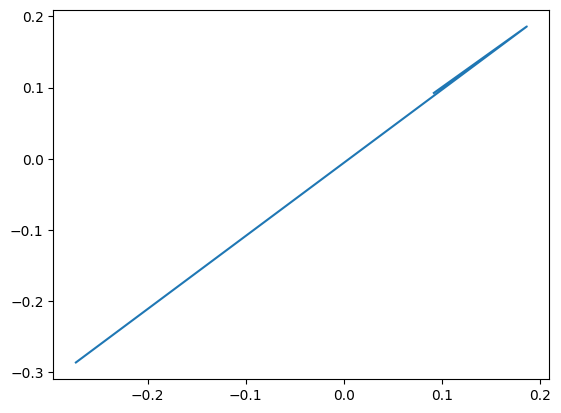

In [33]:
X_array = np.array(X_array).T

plt.figure()
plt.plot(X_array[0],X_array[1])
plt.show()

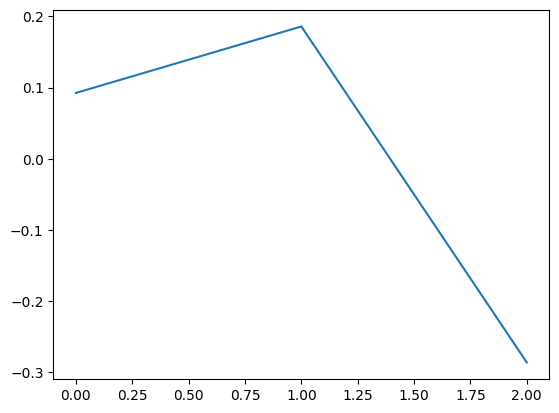

In [34]:
plt.figure()
plt.plot(X_array[2])
plt.show()

In [4]:
stop_Thymio()